In [32]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
import numpy
import scipy
import pandas
import math
import matplotlib
import matplotlib.dates as mpd
import pylab as plt
import datetime as dtm
import pytz
import multiprocessing as mpp
import pickle
import sys
import os
import subprocess
#import lmod
# lmod.load('system')
# lmod.load('texlive')
# lmod.
#
import hpc_lib
#
# TODO: phase out unreferenced hpc_lib calls...
#import hpc_lib
#import hpc_reports
#
def running_mean(X,n=10):
    return (numpy.cumsum(numpy.insert(X,0,0))[n:] - numpy.cumsum(numpy.insert(X,0,0))[:-n])/n
#

## Realtime Monitoring tools

### General objective:
- Some tools to do realtime monitoring of SERC usage
- Nominally more versatile than that; could be SERC, users, groups, etc. 
- Design some metrics to indicate excessive usage; send alerts; make pretty graphs.

Possible starting query:
        squeue -p serc --Format=jobid,jobarrayid,partition,name,userid,timeused,timeleft,numnodes,nodelist,numcpus,state

Use this to identify:
- An individual user or group using >1/3 of the cluster for >1 hour (or so)
- Generally, times of high impact (lots of running and pending jobs)

Note that it is not trivial to estimate this. Loads of jobs pending is not significant, for example, if they have short runtimes. What we really want to catch is a scenario where a job array (or similar) picks up a bunch of idle resources (eg, overnight when usage is lower) for >24 hour runtime jobs.


In [64]:
SP = hpc_lib.SH_PART_obj()

print('** ', SP.get_total_cpus(partitions='serc,normal'))
print('** ', SP.get_total_gpus(partitions='serc,gpu'))

**  13924
**  196


In [46]:
GREs = SP.get_total_gpus(partitions='serc,gpu')

print('** ', SP.get_total_gpus(partitions='serc'))


**  92


In [47]:
print('*** ', SP.SP)

***         partition_name partition_public  nodes_idle  nodes_total  \
normal         normal              yes           0          179   
bigmem         bigmem              yes           1            9   
gpu               gpu              yes           4           26   
dev               dev              yes           1            4   
hns               hns               no           2          105   
serc             serc               no          37          233   
owners         owners               no         152         1471   

        cpu_cores_idle  cpu_cores_total  cpu_cores_queued  gpus_idle  \
normal             141             4820             13612          0   
bigmem             325              504               112          0   
gpu                332              748               124         50   
dev                 96              104                 0         62   
hns                974             3728             20250          0   
serc              2639    

In [48]:
#print('** ', SP.SP)
#gres = SP.SP['GRES(NODE-COUNT)'][['serc', 'gpu']].to_list()
gres = SP.SP['gpus_total'][['serc', 'gpu']].to_list()

In [50]:
print('** ', gres)
print('** ', SP.SP.index)
print('** ', SP.get_col_to_dict('gpus_total', 'serc,normal'))

**  [92, 104]
**  Index(['normal', 'bigmem', 'gpu', 'dev', 'hns', 'serc', 'owners'], dtype='object')
**  {'serc': 92, 'normal': 0}


In [53]:
print('*** ', SP.get_total_gpus(partitions='serc,gpu'))

***  196


In [56]:
    
def sinfo_ncpus_ngpus(partition='serc', as_tuple=False):
    '''
    # get number of cpu CPUs and gpu CPUs and GPUs from sinfo query. Return is like (?)
    #. {'cpu':N_cpu, 'gpu':N_gpu, 'gpu_cpu': N_gpu_cpu)}
    # what is the best output? {'gpu':{'gpu':n, 'cpu',m}} ?{'cpu', 'gpu', 'gpu_cpu'?}
    '''
    #
    sinfo_str = f'sinfo -p {partition} -N --Format=cpus,gres'
    cpus_gres = squeue_output = subprocess.run(sinfo_str.split(),
                                               stdout=subprocess.PIPE).stdout.decode().split('\n')
    #
    cpus_gpus = {'cpu': 0, 'gpu': 0, 'gpu_cpu': 0}
    #
    for k,rw in enumerate(cpus_gres[1:]):
        #
        if len(rw)== 0:
            continue
        cpu,gre = rw.split()
        #
        n_gpu = None
        if 'gpu:' in gre:
            k0 = gre.index('gpu:')
            n_gpu = int(gre[k0+4:gre.index('(',k0)])
            #
            cpus_gpus['gpu'] += n_gpu
            cpus_gpus['gpu_cpu'] += int(cpu)
        else:
            cpus_gpus['cpu'] += int(cpu)
        #
    if as_tuple:
        return (cpus_gpus[ky] for ky in ('cpu', 'gpu', 'gpu_cpu'))
    else:
        return cpus_gpus
    

#
GREs = SP.get_total_gpus(partitions='serc,gpu')
#
print('** GREs: ', GREs)
#
c_g = hpc_lib.sinfo_ncpus_ngpus()
print('c_g: ', c_g)
my_partition='serc, normal'
print(f'** sinfo_ncpus_ngpus: {my_partition}  {hpc_lib.sinfo_ncpus_ngpus(partition=my_partition, as_tuple=True)}' )


** GREs:  196
c_g:  {'cpu': 7712, 'gpu': 92, 'gpu_cpu': 1392}
** sinfo_ncpus_ngpus: serc, normal  (12532, 92, 1392)


In [65]:
# format_fields = {'jobid':str, 'jobarrayid':str, 'partition':str, 'name':str, 'username':str, 'timeused':str, 
#                     'timeleft':str, 'numnodes':int, 'numcpus':int, 'numtasks':int, 'nodelist':str, 'state':str}

# class SQUEUE_obj(object):
#     # SQUEUE manager, principally to estimate realtime SLURM activity. Like SACCT_obj, but
#     #  uses squeue. We *could* use SACCT_obj and just limit to --State=running,pending
#     #. but it seems that sacct is much slower than squeue.
#     #
#     def __init__(self, partition='serc', format_fields_dict=None, squeue_prams=None, verbose=False):
#         #
#         # @squeue_prams: additional or replacement fields for squeue_fields variable, eg parameters
#         #. to pass to squeue. Presently, --Format and --partition are specified. some options might also
#         #. be allowed as regular inputs. Probably .update(squeue_prams) will be the last thing done, so 
#         #  will overried other inputs.
#         #
#         # TODO: add ***kwargs and handle syantax like SQU_{something} to add to squeue_fields, etc.
        
#         if format_fields_dict is None:
#             format_fields_dict = hpc_lib.default_SLURM_types_dict
#         #
#         squeue_fields = {'--Format': ['jobid', 'jobarrayid', 'partition', 'name', 'username', 'timeused', 
#                                       'timeleft', 'numnodes', 'numcpus', 'numtasks', 'state', 'nodelist'],
#                       '--partition': [partition]
#                       }
#         if isinstance(squeue_prams, dict):
#             squeue_fields.update(squeue_prams)
#         #
#         squeue_delim=';'
#         sinfo_str = 'squeue '
#         for ky,vl in squeue_fields.items():
#             delim=' '
#             if ky.startswith('--'):
#                 # long format
#                 delim='='
#             #
#             sinfo_str = '{} {}{}{}'.format(sinfo_str, ky, delim, f':{squeue_delim},'.join(vl))
#         #
#         if verbose:
#             print('*** sinfo_str: {}'.format(sinfo_str))
#             print('*** sinfo_ary: {}'.format(sinfo_str.split()))
#         #
#         # TODO:
#         # port some of these bits to class-scope function calls, for class portability
#         #
#         self.__dict__.update({ky:vl for ky,vl in locals().items() if not ky in ('self', '__class__')})
#         self.set_squeue_data()
#     #
#     def set_squeue_data(self):
#         self.squeue_data = self.get_squeue_data()
#         self.dtype       = self.squeue_data.dtype
#     #
#     def __getitem__(self, *args, **kwargs):
#         return self.squeue_data.__getitem__(*args, **kwargs)
#     def __setitem__(self, *args, kwargs):
#         return self.squeue_data.__setitem__
#     #
#     def get_squeue_data(self, sinfo_str=None, squeue_delim=None, verbose=False):
#         sinfo_str = sinfo_str or self.sinfo_str
#         squeue_delim = squeue_delim or self.squeue_delim
#         #
#         print(f'** squeue: {sinfo_str}' )
#         squeue_output = subprocess.run(sinfo_str.split(), stdout=subprocess.PIPE).stdout.decode().split('\n')
#         #cols = squeue_output[0].split(squeue_delim)
#         #
#         # there is a smarter way to do this, eg:
#         cols = squeue_output[0].split(squeue_delim)
#         for k,cl in enumerate(cols):
#             cl_0 = cl
#             k_rep = 0
#             while cols[k] in cols[0:k]:
#                 cols[k] = f'{cl}_{k_rep}'
#         if verbose:
#             print('** cols: ', cols)
#         #
# #         # DEBUG:
# #         for k,rw in enumerate(squeue_output):
# #             #print(f'** rw[{k}]: {rw.split(squeue_delim)}')
# #             print(f'** rw[{k}]: {rw}')
#         #
#         return pandas.DataFrame(data=[[self.format_fields_dict.get(cl.lower(),str)(x) 
#                                   for x, cl in zip(rw.split(squeue_delim),
#                                 self.squeue_fields['--Format']) ]
#                                  for rw in squeue_output[1:] if not len(rw.strip()) == 0],
#                                    columns=cols).to_records()
#     #
#     def get_active_jobs(self, *args, **kwargs):
#         # print('** DEBUG: args: {}'.format(args))
#         if len(args)>=6:
#             args[5]
#         kwargs['do_jobs'] = True
#         return get_active_cpus(*args, **kwargs)
#     #
#     def get_active_cpus(self, state='running,pending', do_refresh=False, state_data=None, ncpus=None, do_cpus=True, do_jobs=False):
#         if do_refresh:
#             self.set_squeue_data()
#         #
#         if isinstance(state,bytes):
#             state=state.decode()
#         if isinstance(state,str):
#             state=state.split(',')
#         #
#         for k,s in enumerate(state):
#             state[k] = s.upper()
#         #
#         if state_data is None:
#             state_data = self['STATE']
#         if ncpus is None:
#             ncpus = self['CPUS']
#         #
#         ix = numpy.isin(state_data, state)
#         n_jobs, n_cpus = numpy.sum(ix), numpy.sum(ncpus[ix])
#         #
#         if do_cpus and do_jobs:
#             return (n_jobs, n_cpus)
#         if do_cpus:
#             return n_cpus
#         if do_jobs:
#             return n_jobs
#     #
#     def simple_wait_estimate(self, ncpus=1, max_cpus=4600, do_refresh=False):
#         # TODO: figure out the right way(s) to get max_cpus from system.
#         active_cpus = self.get_active_cpus(state='running,pending', do_refresh=do_refresh)
#         avail_cpus = max_cpus - active_cpus
#         #
#         if ncpus <= avail_cpus:
#             return 0
#         #
#         cpus_needed = ncpus - avail_cpus
#         #
#         # now, spin down self['TIME_LEFT'] until we have enough CPUs to do our job. that TIME_LEFT is
#         #. when our job should be available.
#         #
#         return None
#     #
#     def report_user_cpu_job_pies(self, state='RUNNING,PENDING', cpus_total=5456, add_idle=True, ax1=None, ax2=None):
#         #
#         # TODO: use scontrol or sinfo to get an automagical cpus_total count.
#         #
#         user_data = self.get_user_cpu_job_data(state=state, add_idle=add_idle)
#         #
#         if ax1 is None or ax2 is None:
#             fg = plt.figure(figsize=(12,8))
#             ax1 = fg.add_subplot(1,2,1)
#             ax2 = fg.add_subplot(1,2,2)
#         #
#         ax1.pie(user_data['jobs'],  labels=user_data['user'], autopct='%.1f')
#         ax2.pie(user_data['ncpus'], labels=user_data['user'], autopct='%.1f')
#         #
#         ax1.set_title('Jobs', size=16)
#         ax2.set_title('CPUs', size=16)
#         #
#         #ax1.legend(loc=0)
        
#         return user_data
#     #
#     def get_user_cpu_job_data(self, state='RUNNING,PENDING', cpus_total=5456, add_idle=True):
#         #partition = partition or self.partition
#         if isinstance(state,bytes):
#             state=state.decode()
#         if isinstance(state,str):
#             state = state.split(',')
#         sq = self[numpy.isin(self['STATE'].astype(type(state)), state)]
#         print('*** ', self['STATE'].astype(type(state))[0:10], '*** ', state)
#         #
#         users = list([u for u in set(sq['USER']) if not u is None])
#         #if add_idle:
#         #    users += ['idle']
#         print('** users: ', users)
#         #
#         out_data = numpy.empty(shape=(len(users) + int(add_idle),), 
#                     dtype=[('user', f'U{max([len(s) for s in users])}'), ('jobs', '<f8'), ('ncpus', '<f8')])
        
#         #out_data['jobs'] = numpy.zeros(len(users))
#         #out_data['ncpus'] = numpy.zeros(len(users))
#         #
#         # NOTE: there is also a (faster) syntax to broadcast this, then sum on an axis.
#         jobs  = [numpy.sum( (self['USER']==u) ) for u in users]
#         ncpus = [numpy.sum( self['CPUS'][(self['USER']==u)] ) for u in users]
#         #
#         if add_idle:
#             jobs += [0]
#             ncpus += [cpus_total-numpy.sum(ncpus)]
#             users += ['idle']
#         #
#         out_data['user']  = users
#         out_data['jobs']  = jobs
#         out_data['ncpus'] = ncpus
#         #
#         return out_data
        
        
          
        
SQ = hpc_lib.SQUEUE_obj()      
#

** squeue: squeue  --Format=jobid:;,jobarrayid:;,partition:;,name:;,username:;,timeused:;,timeleft:;,numnodes:;,numcpus:;,numtasks:;,state:;,nodelist --partition=serc


In [74]:
#print('** ', 6*128 + 8*128 + 14*24 + 104*32 + 96*32 + 6*128 + 2*64)
print('*** ', SQ.sinfo_str)
print(f'** {SQ.get_active_cpus(state="running") }::{SQ.get_active_cpus(state="pending")}:{SQ.get_active_cpus(state="running,pending")}')
#


***  squeue  --Format=jobid:;,jobarrayid:;,partition:;,name:;,username:;,timeused:;,timeleft:;,numnodes:;,numcpus:;,numtasks:;,state:;,nodelist --partition=serc
** 4927::353:5280


***  ['PENDING' 'COMPLETING' 'PENDING' 'PENDING' 'PENDING' 'PENDING' 'PENDING'
 'PENDING' 'PENDING' 'PENDING'] ***  ['RUNNING', 'PENDING']
** users:  ['pjwomble', 'amyfzou', 'kcoppess', 'tvarg', 'ziwang3', 'jamgalan', 'juliojof', 'iamadden', 'mhqiu', 'cooper96', 'jakin', 'lauraman', 'awan005', 'xiaowen', 'mhzahid', 'haofu', 'nzwang', 'yxy', 'juwoo', 'hytang', 'imcbrear', 'mliu9', 'aljubrmj', 'akawano', 'wenchaot', 'myoder96', 'lblackst', 'ajaffe', 'anovosel', 'mattiafc', 'gegewen', 'jhochsch', 'msutton2', 'tzaquin', 'ovolkov', 'sujiang', 'suihong']
** 
** sunet, nodes, cpus
**  ('pjwomble', 177., 179.)
**  ('amyfzou', 3., 56.)
**  ('kcoppess', 3., 60.)
**  ('tvarg', 2., 256.)
**  ('ziwang3', 2., 256.)
**  ('jamgalan', 10., 147.)
**  ('juliojof', 3., 3.)
**  ('iamadden', 2., 480.)
**  ('mhqiu', 1., 24.)
**  ('cooper96', 4., 64.)
**  ('jakin', 1., 4.)
**  ('lauraman', 26., 201.)
**  ('awan005', 1., 1.)
**  ('xiaowen', 2., 19.)
**  ('mhzahid', 1., 56.)
**  ('haofu', 2., 288.)
**  ('nzwang

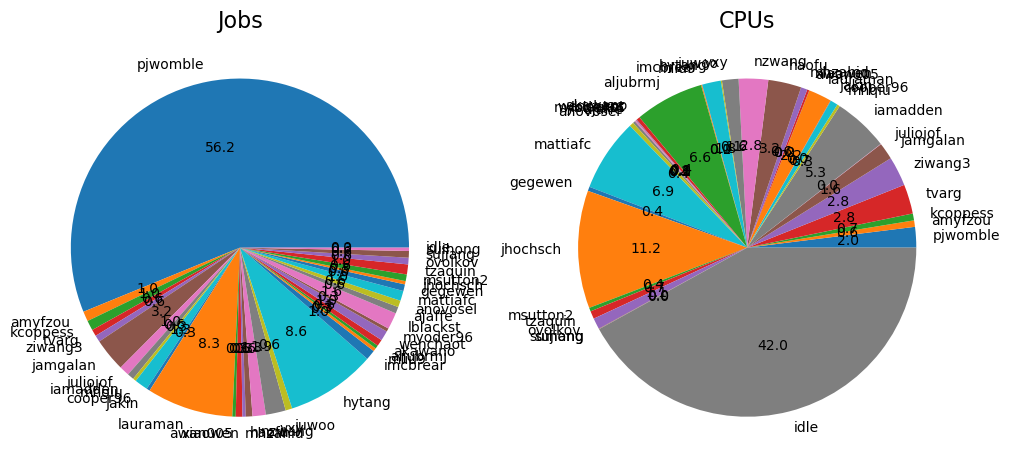

In [75]:
# users = list([u for u in set(SQ['USER']) if not u is None])
# print('** ', users)
#         #
# out_data = numpy.empty(shape=(len(users),), 
#             dtype=[('user', f'U{max([len(s) for s in users])}'), ('jobs', '<f8'), ('ncpus', '<f8')])
# out_data['user'] = users
# out_data['jobs'] = numpy.zeros(len(users))
# out_data['ncpus'] = numpy.zeros(len(users))
# #
# print('** ', out_data)

user_pie = SQ.report_user_cpu_job_pies()
print('** ')
print('** sunet, nodes, cpus')
for rw in user_pie:
    print('** ', rw)

In [76]:
print('** sum, ', numpy.sum(user_pie['ncpus']))

** sum,  9104.0


In [77]:
#SQ.set_squeue_data()
print('** users: ', set(SQ['USER']))
#
print('** ', SQ['TIME'][0:20])
print('** ', SQ['TIME_LEFT'][0:20])
print('** ', hpc_lib.elapsed_time_2_day('13:14:10'))

** users:  {'pjwomble', 'amyfzou', 'kcoppess', 'tvarg', 'ziwang3', 'jamgalan', 'juliojof', 'iamadden', 'mhqiu', 'cooper96', 'jakin', 'lauraman', 'awan005', 'xiaowen', 'mhzahid', 'haofu', 'nzwang', 'yxy', 'juwoo', 'hytang', 'imcbrear', 'mliu9', 'aljubrmj', 'akawano', 'wenchaot', 'myoder96', 'lblackst', 'ajaffe', 'anovosel', 'mattiafc', 'gegewen', 'jhochsch', 'msutton2', 'tzaquin', 'ovolkov', 'sujiang', 'suihong'}
**  [0.         0.00194444 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
**  [0.04097222 0.03902778 3.         1.         1.         1.
 1.         3.         0.02083333 0.02083333 0.02083333 0.02083333
 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333
 0.02083333 0.02083333]
**  0.5515046296296297


In [83]:
#print('** ', SQ.format_fields_dict.keys())

print('** ', SQ.format_fields_dict['TIMELEFT'])
print('** ', SQ.dtype)
SQ.get_active_cpus(do_jobs=True, do_cpus=True)

**  <function elapsed_time_2_day at 0x7f7604d3e980>
**  (numpy.record, [('index', '<i8'), ('JOBID', 'O'), ('JOBID_0', 'O'), ('PARTITION', 'O'), ('NAME', 'O'), ('USER', 'O'), ('TIME', '<f8'), ('TIME_LEFT', '<f8'), ('NODES', '<i8'), ('CPUS', '<i8'), ('TASKS', '<i8'), ('STATE', 'O'), ('NODELIST            ', 'O')])


(314, 5280)

In [ ]:
print('** ', SQ['STATE'][0:20])
ix = [s in ['RUNNING'] for s in SQ['STATE'] ]

#print('** ', ix)
